# Learned geometry parameterization: WGAN-GP

The goal of the tutorial is to demonstrate how to use a generative adversarial network to re-parameterize image-based geometries into a regularized latent space that is simple to constrain to the interpolation regime.

## Import modules

In [1]:
import pickle
import os

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import h5py
import numpy as np
from sklearn.model_selection import train_test_split

import helper

# Dynamic GPU memory allocation: For local prototyping, don't block GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)


2023-06-30 17:02:22.148056: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 17:02:22.718181: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-30 17:02:23.843028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:02:23.861203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

## load the training data

In [2]:
data_path = 'datasets/dataset3_nanoscat.h5'

with h5py.File(data_path, "r") as f:
    geo = np.array(f['geo2d'], dtype=np.float32)
geo = geo*2 - 1     # rescale from -1 to 1

geo_train, geo_val = train_test_split(
    geo, test_size=0.1, shuffle=True, random_state=12345)

print(geo_train.shape, geo_val.shape)


(14400, 20, 20, 1) (1600, 20, 20, 1)


### WGAN resnet model

*Note*, instead of `MaxPooling`, we here use `strides=2` to reduce the output dimension of a convolution by a factor of 2. In the up-sampling case (see forward model), strides can also be used with transpose convolutions to increase the output dimension. However the latter often leads to artifacts in the upsampled outputs, therefore for a robust first try dedicated `UpSampling` layers are preferred. 

In the down-sampling case, strides usually don't induce artifacts and are computationally cheaper as well as are more flexible (they are trainable), in contrast to `MaxPooling`.

First we define a helpers to generate sequences of `N_block` residual blocks:

In [3]:
def resblock_sequence_down(x_in, N_filter, N_blocks, with_BN):
    x = x_in
    for i in range(N_blocks):
        x = helper.residual_block(
            x, N_filter, conv_layer=keras.layers.Conv2D,
            kernel_size=3, strides=1, with_BN=with_BN)
    # down: use strides=2 for downsampling (more flexible, since trainable).
    x = helper.residual_block(
        x, N_filter, conv_layer=keras.layers.Conv2D,
        kernel_size=3, strides=2, with_BN=with_BN)
    return x


def resblock_sequence_up(x_in, N_filter, N_blocks, with_BN):
    x = x_in
    for i in range(N_blocks):
        x = helper.residual_block(
            x, N_filter, conv_layer=keras.layers.Conv2DTranspose,
            kernel_size=3, strides=1, with_BN=with_BN)
    # up: use upsampling (more robust than transpose convolutions with stride 2)
    x = keras.layers.UpSampling2D()(x)
    return x


## define the generator

Similar to the cVAE, the cGAN consists of two parts. The first part is the generator, taking the generation condition (here a design target spectrum) and a latent variable as input. The generator corresponds to the decoder in the cVAE. The second part is the discriminator, that takes as inputs a geometry and the according design condition (spectrum). This discrimonator part corresponds to the cVAE encoder, but instead of a latent representation, it returns an estimation whether the geometry is true or fake (generated). It can be seen as a trainable loss function. 

Here, we use a Wasserstein GAN, where the discriminator output will be trained with a Wasserstein distance loss funtion. Compared to the min-max loss of the original GAN, the WGAN offers a stable and much mor robust convergence. It is significantly easier to implement, since the Wasserstein loss is much more robust with respect to hyperparameter choice [Arjovsky, M., Chintala, S. & Bottou, L. *Wasserstein GAN.* https://doi.org/10.48550/arXiv.1701.07875 (2017)]. Additionally we employ gradient penalty as regularization, which further improves the robustness of GAN training ("WGAN-GP", [Gulrajani, I., Ahmed, F., Arjovsky, M., Dumoulin, V. & Courville, A. *Improved Training of Wasserstein GANs.* https://doi.org/10.48550/arXiv.1704.00028 (2017)]).

2023-06-30 17:02:24.526460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:02:24.526662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:02:24.526786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 2304)         117504      ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2304)        9216        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 2304)         0           ['batch_normalization[0][0]']

2023-06-30 17:02:26.164952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-30 17:02:26.287194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


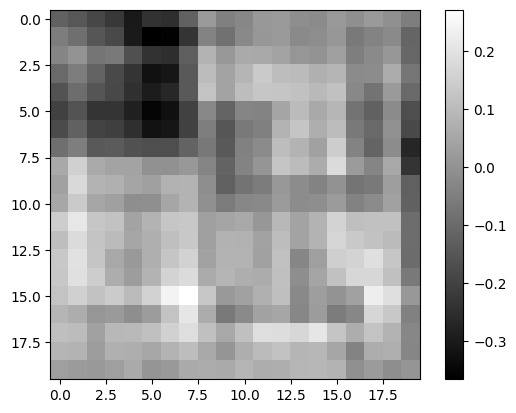

In [4]:
keras.backend.clear_session()

# some config for the cVAE
latent_dim = 50
N_blocks = 3     # Nr of resblocks between up/down-samplings
with_BN = True  # train generator with BN (discriminator without)


def create_G(latent_dim, geo_out_N_channels, with_BN):
    noise_in = keras.layers.Input(shape=latent_dim)
    x = noise_in

    x = keras.layers.Dense(3*3*256)(x)
    if with_BN:
        x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Reshape((3, 3, 256))(x)

    x = resblock_sequence_up(
        x, N_filter=256, N_blocks=N_blocks, with_BN=with_BN)  # 3 --> 6
    x = keras.layers.Cropping2D(cropping=((0, 1), (0, 1)))(x)       # 6 --> 5
    x = resblock_sequence_up(
        x, N_filter=128, N_blocks=N_blocks, with_BN=with_BN)  # 5 --> 10
    x = resblock_sequence_up(
        x, N_filter=64, N_blocks=N_blocks, with_BN=with_BN)  # 10 --> 20

    x = keras.layers.Conv2D(
        geo_out_N_channels, kernel_size=3, padding='same')(x)
    geo_out_tanh = keras.layers.Activation('tanh')(x)  # scale from -1 to 1

    generator = keras.Model(noise_in, geo_out_tanh)
    return generator


generator = create_G(latent_dim, geo_train.shape[-1], with_BN)
generator.summary()

# test
noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()


## Discriminator

The discriminator acts as a trained loss function, taking geometry and according spectrum as input, with the goal to estimate whether the design is true or NN-generated. It is somewhat equivalent to the encoder in the VAE architecture.

The WGAN paper notes that there should be no batchnorm in the discriminator network because it would falsify the statistics.

In [5]:
with_BN = False  # train discriminator without BN (generator with)


def create_D(geo_out_shape, with_BN):

    # --- input layer
    geo_in = keras.layers.Input(shape=geo_out_shape)
    x = geo_in

    # --- CNN 2D part downsizing
    x = resblock_sequence_down(
        x, N_filter=64, N_blocks=N_blocks, with_BN=with_BN)  # 20 --> 10
    x = resblock_sequence_down(
        x, N_filter=128, N_blocks=N_blocks, with_BN=with_BN)  # 10 --> 5
    x = resblock_sequence_down(
        x, N_filter=256, N_blocks=N_blocks, with_BN=with_BN)  # 5 --> 3

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128)(x)
    x = keras.layers.LeakyReLU(0.1)(x)

    # LSGAN: linear output activation!
    is_true_out = keras.layers.Dense(1)(x)
    # is_true_out = layers.Activation('sigmoid')(is_true_out)

    discriminator = keras.Model(geo_in, is_true_out)
    return discriminator


discriminator = create_D(geo_train.shape[1:], with_BN)
discriminator.summary()

# test
decision = discriminator(generated_image)
print(decision)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20, 20, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 20, 20, 64)   128         ['input_2[0][0]']                
                                                                                                  
 leaky_re_lu_28 (LeakyReLU)     (None, 20, 20, 64)   0           ['conv2d_2[0][0]']               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 20, 20, 64)   36928       ['leaky_re_lu_28[0][0]']         
                                                                                            

## Define the full cWGAN-GP model

Because of the specific training procedure, we implement the full model as a separate keras model class.



In [6]:
class WGAN_GP(keras.Model):
    """Adapted from the Apache 2.0 licenced keras tutorial (original author A. K. Nain):
    https://keras.io/examples/generative/wgan_gp/
    """

    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()  # base class compile function
        # set WGAN-specific losses and optimizers
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_struct, fake_struct):
        """Calculate the gradient penalty using fast sample interpolation"""
        # Get the interpolated image and its discriminator result
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_struct - real_struct
        interpolated = real_struct + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        # gradients, their norm & penalty
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)

        return gp

    def train_step(self, real_struct):
        if isinstance(real_struct, tuple):
            real_struct = real_struct[0]
        batch_size = tf.shape(real_struct)[0]

        # ----- Train discriminator (for d_steps times)
        for i in range(self.d_steps):
            # normal random latent --> automatically regularized
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # generate fake samples for latent and predict with discriminator
                fake_struct = self.generator(
                    random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_struct, training=True)
                # predict real samples with discriminator
                real_logits = self.discriminator(real_struct, training=True)

                # discriminator loss between fake and real & gradient penalty
                d_cost = self.d_loss_fn(
                    real_struct=real_logits, fake_struct=fake_logits)
                gp = self.gradient_penalty(
                    batch_size, real_struct, fake_struct)
                d_loss_full = d_cost + gp * self.gp_weight

            # update weights:
            d_gradient = tape.gradient(
                d_loss_full, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # ----- train generator (one single time)
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images with generator and predict with discriminator
            generated_struct = self.generator(
                random_latent_vectors, training=True)
            gen_struct_logits = self.discriminator(
                generated_struct, training=True)
            # generator loss
            g_loss_full = self.g_loss_fn(gen_struct_logits)

        # update weights
        gen_gradient = tape.gradient(
            g_loss_full, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss_full, "g_loss": g_loss_full}


## Monitor to plot samples during training

In [7]:
# %% monitor to sample images from time to time
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, N_epoch_plot, N_img_x, N_img_y, latent_dim):
        self.N_epoch_plot = N_epoch_plot
        self.latent_dim = latent_dim
        self.c = N_img_x
        self.r = N_img_y

    # generate sample images on each epoch
    def on_epoch_end(self, epoch, logs=None):
        if epoch%self.N_epoch_plot == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.r*self.c, self.latent_dim))
            gen_imgs = self.model.generator.predict(random_latent_vectors)

            fig, axs = plt.subplots(self.r, self.c)
            cnt = 0
            for i in range(self.r):
                for j in range(self.c):
                    plt.sca(axs[i, j])
                    _im = axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                    plt.colorbar(_im)
                    axs[i, j].axis('off')
                    cnt += 1
            plt.show()


## Train the GAN end-to-end

Train the GAN via wasserstein and gradient-penalty losses, monitor generated images through the training.

### A note on GAN latent space regularization

VAEs require a random sampling layer and a KL loss in order to regularize the latent space. The GAN does not require a specific layer, neither a KL Loss. During GAN training, we generate random samples in the training loop and we set the mean to zero and variance to 1 at generation. These random inputs are then learned to be converted to a design. Thus, the regularization is in fact implicit in the GAN approach.

In [8]:
# optimizers
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.00005, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.00005, beta_1=0.5, beta_2=0.9
)

# losses


def discriminator_loss(real_struct, fake_struct):
    real_loss = tf.reduce_mean(real_struct)
    fake_loss = tf.reduce_mean(fake_struct)
    return fake_loss - real_loss


def generator_loss(fake_struct):
    return -tf.reduce_mean(fake_struct)


# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(N_epoch_plot=2, N_img_x=3, N_img_y=5, 
                 latent_dim=latent_dim)

# construct the full cWGAN using our G and D networks
wgan = WGAN_GP(
    discriminator=discriminator,
    generator=generator,
    latent_dim=latent_dim,
)

Epoch 1/15


2023-06-30 17:02:50.169845: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f2788858d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-30 17:02:50.169866: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-06-30 17:02:50.173200: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-30 17:02:50.290973: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 1s 900ms/step d_loss: -4.3701 - g_loss: -9.11


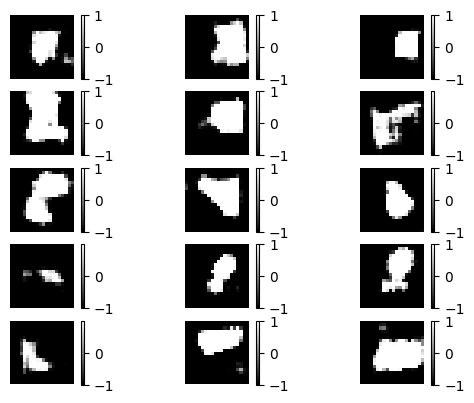

225/225 [==============================] - 67s 142ms/step - d_loss: -4.3737 - g_loss: -9.1148
Epoch 2/15
225/225 [==============================] - 30s 134ms/step - d_loss: -6.0957 - g_loss: -12.1219
Epoch 3/15
1/1 [==============================] - 0s 27ms/step- d_loss: -5.9277 - g_loss: -13.64


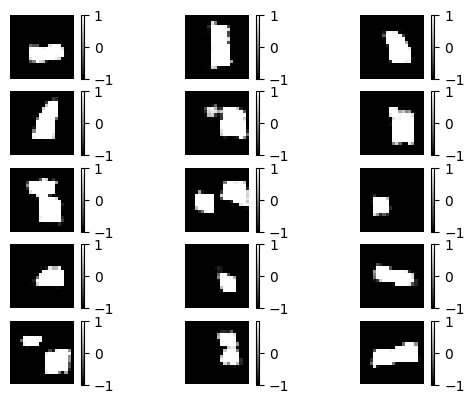

225/225 [==============================] - 30s 135ms/step - d_loss: -5.9296 - g_loss: -13.6623
Epoch 4/15
225/225 [==============================] - 30s 135ms/step - d_loss: -5.6836 - g_loss: -27.9060
Epoch 5/15
1/1 [==============================] - 0s 26ms/step- d_loss: -5.5845 - g_loss: -38.38


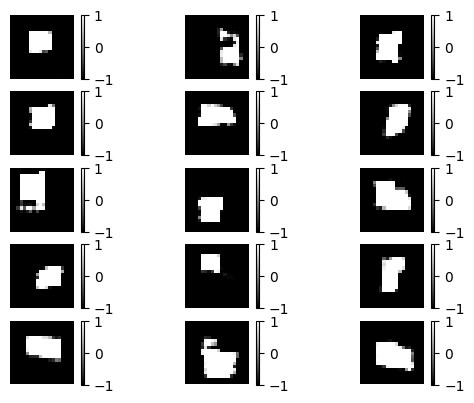

225/225 [==============================] - 31s 136ms/step - d_loss: -5.5830 - g_loss: -38.4077
Epoch 6/15
225/225 [==============================] - 30s 133ms/step - d_loss: -5.4556 - g_loss: -45.5736
Epoch 7/15
1/1 [==============================] - 0s 27ms/step- d_loss: -5.2492 - g_loss: -52.71


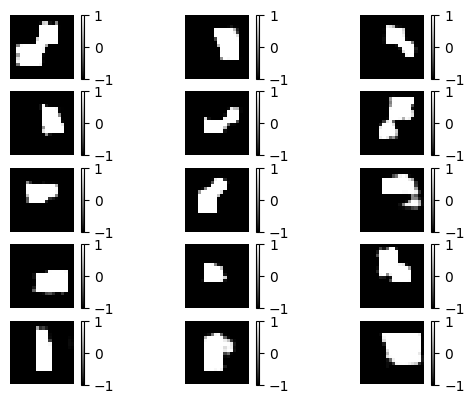

225/225 [==============================] - 31s 137ms/step - d_loss: -5.2465 - g_loss: -52.7282
Epoch 8/15
225/225 [==============================] - 30s 132ms/step - d_loss: -5.2937 - g_loss: -56.4147
Epoch 9/15
1/1 [==============================] - 0s 86ms/step- d_loss: -5.4162 - g_loss: -57.67


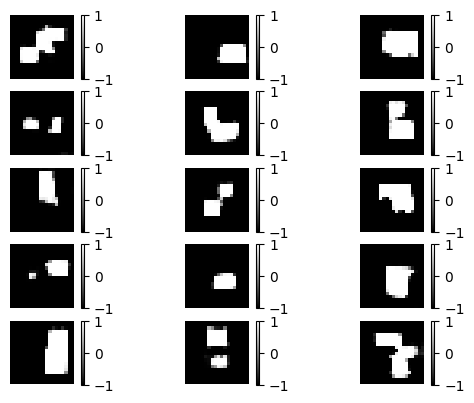

225/225 [==============================] - 31s 136ms/step - d_loss: -5.4217 - g_loss: -57.6450
Epoch 10/15
225/225 [==============================] - 30s 135ms/step - d_loss: -5.3629 - g_loss: -55.4116
Epoch 11/15
1/1 [==============================] - 0s 26ms/step- d_loss: -5.2792 - g_loss: -53.96


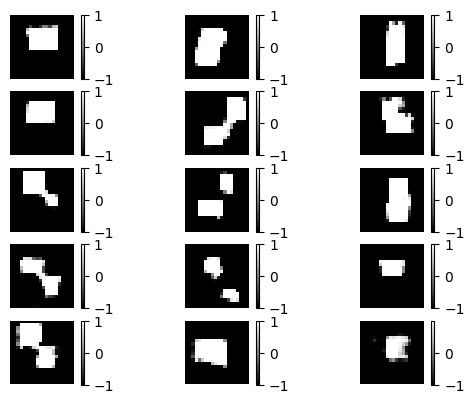

225/225 [==============================] - 31s 139ms/step - d_loss: -5.2770 - g_loss: -53.9793
Epoch 12/15
225/225 [==============================] - 30s 134ms/step - d_loss: -5.2202 - g_loss: -52.3038
Epoch 13/15
1/1 [==============================] - 0s 25ms/step- d_loss: -5.1852 - g_loss: -50.72


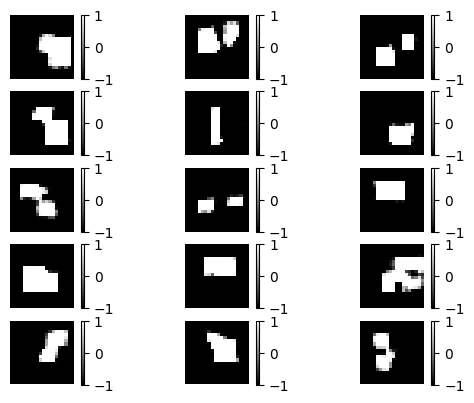

225/225 [==============================] - 31s 138ms/step - d_loss: -5.1880 - g_loss: -50.7061
Epoch 14/15
225/225 [==============================] - 30s 133ms/step - d_loss: -5.0843 - g_loss: -49.7008
Epoch 15/15
1/1 [==============================] - 0s 38ms/step- d_loss: -5.1630 - g_loss: -50.06


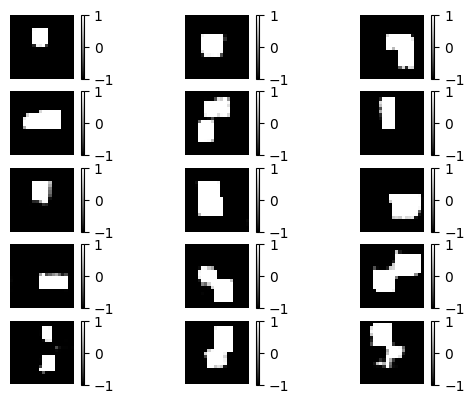

225/225 [==============================] - 31s 137ms/step - d_loss: -5.1639 - g_loss: -50.0633
Epoch 1/15
1/1 [==============================] - 0s 27ms/step- d_loss: -4.9983 - g_loss: -49.53


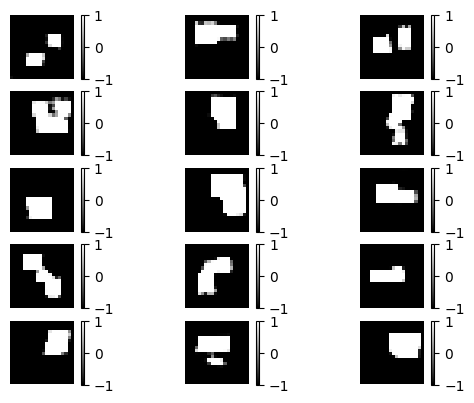

113/113 [==============================] - 42s 208ms/step - d_loss: -4.9973 - g_loss: -49.5508
Epoch 2/15
113/113 [==============================] - 23s 201ms/step - d_loss: -4.8761 - g_loss: -49.8153
Epoch 3/15
1/1 [==============================] - 0s 16ms/step- d_loss: -4.8137 - g_loss: -48.79


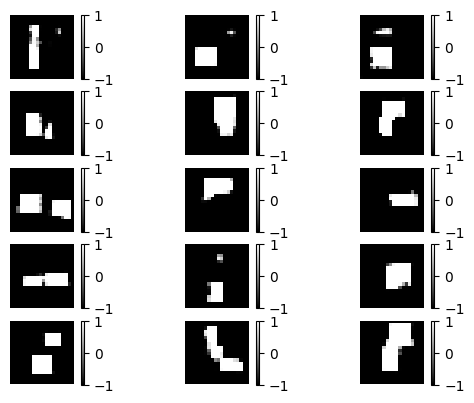

113/113 [==============================] - 24s 208ms/step - d_loss: -4.8185 - g_loss: -48.8049
Epoch 4/15
113/113 [==============================] - 23s 202ms/step - d_loss: -4.7676 - g_loss: -48.8644
Epoch 5/15
1/1 [==============================] - 0s 25ms/step- d_loss: -4.6944 - g_loss: -47.06


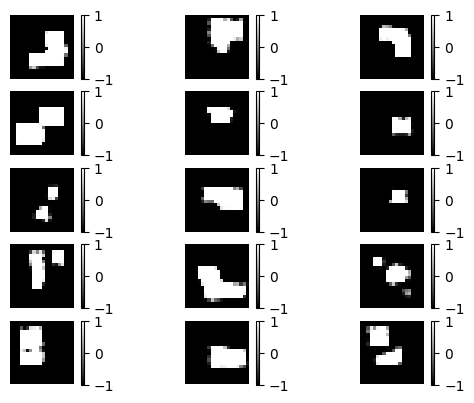

113/113 [==============================] - 24s 211ms/step - d_loss: -4.6888 - g_loss: -47.0767
Epoch 6/15
113/113 [==============================] - 22s 199ms/step - d_loss: -4.7405 - g_loss: -45.9334
Epoch 7/15
1/1 [==============================] - 0s 27ms/step- d_loss: -4.6600 - g_loss: -44.34


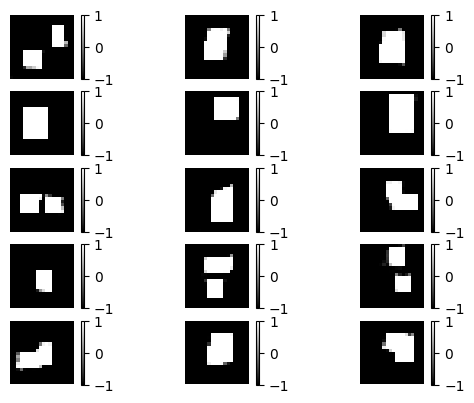

113/113 [==============================] - 22s 198ms/step - d_loss: -4.6587 - g_loss: -44.2804
Epoch 8/15
113/113 [==============================] - 24s 211ms/step - d_loss: -4.6692 - g_loss: -43.1153
Epoch 9/15
1/1 [==============================] - 0s 26ms/step- d_loss: -4.6486 - g_loss: -42.50


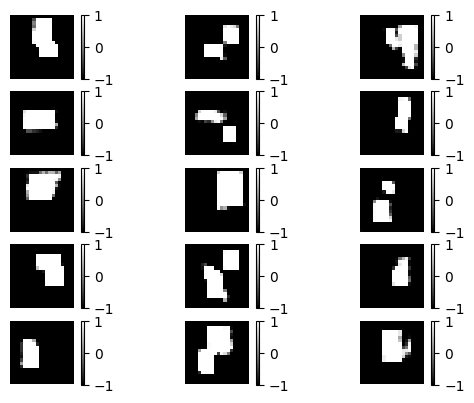

113/113 [==============================] - 25s 218ms/step - d_loss: -4.6488 - g_loss: -42.4422
Epoch 10/15
113/113 [==============================] - 24s 213ms/step - d_loss: -4.5928 - g_loss: -42.1732
Epoch 11/15
1/1 [==============================] - 0s 27ms/step- d_loss: -4.4956 - g_loss: -41.53


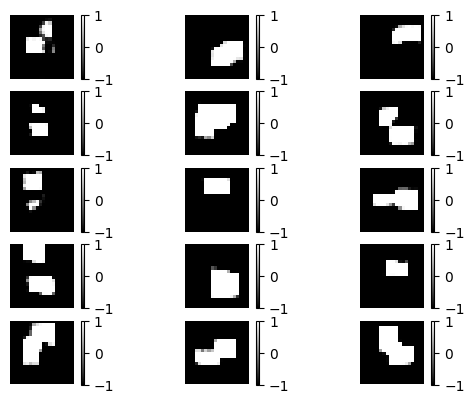

113/113 [==============================] - 25s 221ms/step - d_loss: -4.5027 - g_loss: -41.5225
Epoch 12/15
113/113 [==============================] - 24s 211ms/step - d_loss: -4.5017 - g_loss: -42.6780
Epoch 13/15
1/1 [==============================] - 0s 26ms/step- d_loss: -4.4727 - g_loss: -41.84


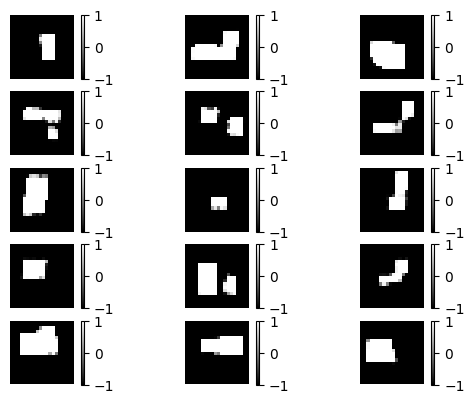

113/113 [==============================] - 25s 218ms/step - d_loss: -4.4708 - g_loss: -41.8418
Epoch 14/15
113/113 [==============================] - 24s 213ms/step - d_loss: -4.3720 - g_loss: -39.9428
Epoch 15/15
1/1 [==============================] - 0s 24ms/step- d_loss: -4.4017 - g_loss: -40.01


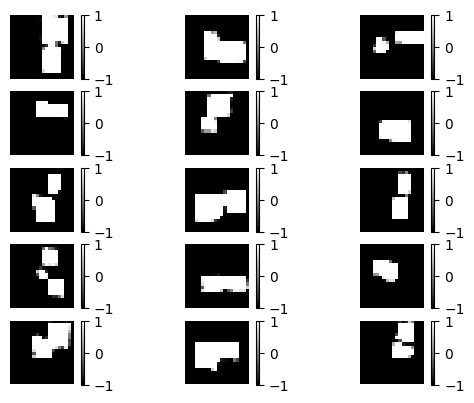

113/113 [==============================] - 21s 181ms/step - d_loss: -4.4064 - g_loss: -39.9951


In [9]:
# Compile the wgan model with losses and optimizers
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training
N_epochs_per_BS = 15
for batch_size in [64, 128]:
    wgan.fit(geo_train, batch_size=batch_size,
             epochs=N_epochs_per_BS, callbacks=[cbk])


## save the WGAN Generator

In [10]:
# save
generator.save('models/WGANGP_image_G.h5')